# Licence Plate Recognition with YOLOv11 + PaddleOCR

Задача данного проекта состоит в том, чтобы наилучшим образом распознать автомобильные номера. 
Для решения данной задачи поделим её на две части: детекция (YOLOv11) и распознавание (PaddleOCR). 

# Часть первая. Детекция автомобильных номеров

In [2]:
import os
import cv2
import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision.io import read_image
import matplotlib.patches as patches
from pathlib import Path
from glob import glob
import shutil
import yaml

from ultralytics import YOLO

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
cuda


У нас есть ~4к тренировочных размеченных изображений, ~1.3к тренировочных тестовых данных без разметки, и ~3.5к неразмеченных данных, которые мы используем для тренировки (или валидации). 

Также у нас имеется текстовый файл с аннотациями, в котором записано имя файла с изображением, gt координаты bounding boxes и gt автомобильный номер. 
Для первой части стоящей перед нами задачи, нам понадобится всё, кроме номера.

Изучим данные и подготовим датафрейм.

Посмотрим на пример ниже. На данном изображении мы можем заметить два автомобильных номера: и это не редкий случай в данном датасете, т.к. они в основном китайские.

In [4]:
data_path = '/kaggle/input/car-plate/data_jpg'

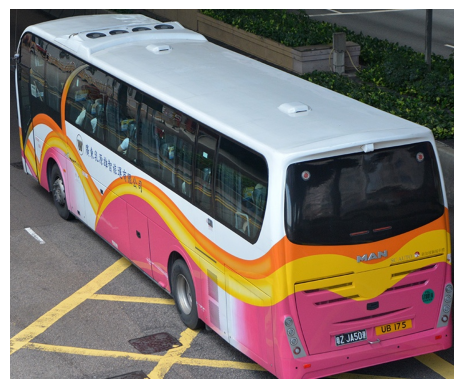

In [9]:
img_path = os.path.join(data_path, 'images/train/000000_0.jpg')
img = read_image(img_path)

plt.axis('off')
plt.imshow(img.permute(1, 2, 0))
plt.show()

Теперь создадим датафрейм из нашего текстового файла с аннотациями. 

Как видим на самой первой строчке (или вживую на изображении выше черный автомобильный номер), периодически встречаются номера с китайскими иероглифами. Это немного усложняет задачу и добавляет в неё некоторого экстрима, хоть и это делает её достаточно интересной, но это я забегаю вперёд :)

In [5]:
cols=['image_name', 'x_1', 'y_1', 'x_2', 'y_2', 'plate']
annot_path = os.path.join(data_path, 'annotation/train_final_annot.txt')
df = pd.read_csv(annot_path, sep=",", names=cols, skiprows=1, header=None)
df.head()

,image_name,x_1,y_1,x_2,y_2,plate
0,train/000000_0.jpg,566,558,626,586,粤ZJA50港
1,train/000000_0.jpg,635,538,705,570,UB175
2,train/000001_0.jpg,1003,791,1160,831,MB3185
3,train/000002_0.jpg,1077,565,1209,604,NG8134
4,train/000004_0.jpg,972,627,1120,668,TT583


Датафрейм выше состоит из изображений, которые размечены. Но у нас также есть неразмеченные данные, которые мы хотим тоже использовать для train/val. Размечать самому примерно 3.5к изображений, ещё и бесплатно, как-то не очень хотелось. Как же решить эту проблему? 

А решение есть! Есть замечательная (хоть так и просящая танцы с бубном при установке из-за поломок каких-нибудь зависимостей библиотек) модель GroundingDino! С помощью текстового промпта удалось создать псевдоразметки довольно быстро, что не может не радовать. Тем более, что с ними качество модели возрастает. Но это я тоже забегаю вперёд:)

Результаты данной разметки записаны в csv, так давайте их используем. 

In [6]:
df_na = pd.read_csv('/kaggle/input/csv-file/not_annotated.csv')
df_na.head()

,image_name,x_1,y_1,x_2,y_2
0,not_annotated/002541_0.jpg,755.440550,91.290855,785.85010,119.11942
1,not_annotated/002541_0.jpg,694.310850,266.618350,842.25240,316.14240
2,not_annotated/000376_0.jpg,53.724410,610.790160,284.54248,767.30615
3,not_annotated/3361.jpg,1184.829800,565.816830,1320.41850,657.44977
4,not_annotated/1656.jpg,40.070023,68.110710,75.32835,83.46694


Давайте визуализируем bounding boxes и убедимся, что всё хорошо разметилось. Напишем для этого функцию:

In [29]:
def visualize_bounding_box(image, xmin, ymin, xmax, ymax):
    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy() 
    image_np = image[:, :, ::-1]
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    
    # Добавляем точки на изображение
    ax.scatter(xmin, ymin, color='white', s=10, marker='o')
    ax.scatter(xmax, ymax, color='white', s=10, marker='o')
    ax.text(xmin, ymin, f'[{xmin}, {ymin}]', fontsize=10, color='white', ha='right', va='bottom')
    ax.text(xmax, ymax, f'[{xmax}, {ymax}]', fontsize=10, color='white', ha='left', va='top')
    
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    
    plt.show();

In [20]:
data_path = data_path + '/images'

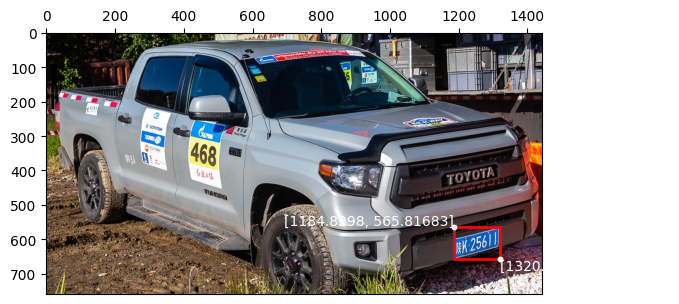

In [38]:
img_na = cv2.imread(os.path.join(data_path, df_na.iloc[3]['image_name']))
x1, y1, x2, y2 = df_na[['x_1', 'y_1','x_2', 'y_2']].iloc[3].to_numpy()
visualize_bounding_box(img_na, x1, y1, x2, y2)

Всё супер!

Теперь объединим два этих датасета в один датафрейм. Пока выкинем номера.

In [32]:
df_new = pd.concat([df.drop('plate', axis=1), df_na], ignore_index=True)
df_new.tail()

,image_name,x_1,y_1,x_2,y_2
7558,not_annotated/004213_0.jpg,0.044220,3.570465,364.04102,545.48010
7559,not_annotated/3919.jpg,189.251160,453.578640,292.30823,492.07840
7560,not_annotated/2193.jpg,152.288540,193.285600,236.46304,228.20757
7561,not_annotated/3863.jpg,81.452540,128.422260,153.77362,161.10829
7562,not_annotated/004322_3.jpg,0.808548,113.338060,425.27148,452.82587


Для удобства добавим image_path.

In [33]:
df_new['image_path'] = '/kaggle/input/car-plate/data_jpg/images/' + df_new['image_name'] 

In [34]:
df_new

,image_name,x_1,y_1,x_2,y_2,image_path
0,train/000000_0.jpg,566.000000,558.000000,626.00000,586.00000,/kaggle/input/car-plate/data_jpg/images/train/...
1,train/000000_0.jpg,635.000000,538.000000,705.00000,570.00000,/kaggle/input/car-plate/data_jpg/images/train/...
2,train/000001_0.jpg,1003.000000,791.000000,1160.00000,831.00000,/kaggle/input/car-plate/data_jpg/images/train/...
3,train/000002_0.jpg,1077.000000,565.000000,1209.00000,604.00000,/kaggle/input/car-plate/data_jpg/images/train/...
4,train/000004_0.jpg,972.000000,627.000000,1120.00000,668.00000,/kaggle/input/car-plate/data_jpg/images/train/...
...,...,...,...,...,...,...
7558,not_annotated/004213_0.jpg,0.044220,3.570465,364.04102,545.48010,/kaggle/input/car-plate/data_jpg/images/not_an...
7559,not_annotated/3919.jpg,189.251160,453.578640,292.30823,492.07840,/kaggle/input/car-plate/data_jpg/images/not_an...
7560,not_annotated/2193.jpg,152.288540,193.285600,236.46304,228.20757,/kaggle/input/car-plate/data_jpg/images/not_an...
7561,not_annotated/3863.jpg,81.452540,128.422260,153.77362,161.10829,/kaggle/input/car-plate/data_jpg/images/not_an...


Но для YOLO данный формат разметки не подходит. 

Сделаем из Pascal VOC (x1, y1, x2, y2) -> YOLO (x_center_norm, y_center_norm, width_norm, height_norm)

In [39]:
def pascal_voc_to_yolo_boxes(image, xmin, ymin, xmax, ymax):
    _, height, width = image.shape
    h = [ymax+ymin, ymax-ymin]
    w = [xmax+xmin, xmax-xmin]
    x_center = w[0]/2
    y_center = h[0]/2
    
    x_center_norm = x_center/width
    y_center_norm =  y_center/height
    width_norm = w[1]/width
    height_norm = h[1]/height
    yolo_bbox = [x_center_norm, y_center_norm, width_norm, height_norm]
    
    return yolo_bbox

In [40]:
def process_row(row):
    img = read_image(row['image_path'])
    return pascal_voc_to_yolo_boxes(img, row.x_1, row.y_1, row.x_2, row.y_2)

results = df_new.apply(process_row, axis=1)
df_new[['x_c', 'y_c', 'w', 'h']] = pd.DataFrame(results.tolist(), index=df_new.index)

In [41]:
df_new

,image_name,x_1,y_1,x_2,y_2,image_path,x_c,y_c,w,h
0,train/000000_0.jpg,566.000000,558.000000,626.00000,586.00000,/kaggle/input/car-plate/data_jpg/images/train/...,0.768041,0.885449,0.077320,0.043344
1,train/000000_0.jpg,635.000000,538.000000,705.00000,570.00000,/kaggle/input/car-plate/data_jpg/images/train/...,0.863402,0.857585,0.090206,0.049536
2,train/000001_0.jpg,1003.000000,791.000000,1160.00000,831.00000,/kaggle/input/car-plate/data_jpg/images/train/...,0.767021,0.871106,0.111348,0.042965
3,train/000002_0.jpg,1077.000000,565.000000,1209.00000,604.00000,/kaggle/input/car-plate/data_jpg/images/train/...,0.795407,0.829078,0.091858,0.055319
4,train/000004_0.jpg,972.000000,627.000000,1120.00000,668.00000,/kaggle/input/car-plate/data_jpg/images/train/...,0.772526,0.806351,0.109306,0.051059
...,...,...,...,...,...,...,...,...,...,...
7558,not_annotated/004213_0.jpg,0.044220,3.570465,364.04102,545.48010,/kaggle/input/car-plate/data_jpg/images/not_an...,0.500117,0.490224,0.999991,0.967696
7559,not_annotated/3919.jpg,189.251160,453.578640,292.30823,492.07840,/kaggle/input/car-plate/data_jpg/images/not_an...,0.252920,0.959084,0.108253,0.078093
7560,not_annotated/2193.jpg,152.288540,193.285600,236.46304,228.20757,/kaggle/input/car-plate/data_jpg/images/not_an...,0.637298,0.780543,0.275982,0.129341
7561,not_annotated/3863.jpg,81.452540,128.422260,153.77362,161.10829,/kaggle/input/car-plate/data_jpg/images/not_an...,0.532186,0.462509,0.327245,0.104428


Отлично, мы почти готовы! Разделим наши тренировочные данные на train/val.

In [42]:
# Позаботимся о воспроизводимости 
def enable_determinism():
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.use_deterministic_algorithms(True)

def fix_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)


enable_determinism()
fix_seeds(24)

Разделим именно по названиям изображений, т.к. из-за того, что на картинке может быть несколько bboxes, название файла может дублироваться. И если мы просто случайно разделим таблицу, то есть шанс того, что картинка попадет и в тренировочную, и валидационную выборку. Нам такого не надо.

In [43]:
unique_images = df_new['image_name'].unique() 
np.random.shuffle(unique_images)
 
# 10% на валидацию
val_size = int(0.1 * len(unique_images))
val_images = set(unique_images[:val_size])
train_images = set(unique_images[val_size:])
 
df_train = df_new[df_new['image_name'].isin(train_images)]
df_val = df_new[df_new['image_name'].isin(val_images)]
 
print(f"Train images: {len(train_images)}")
print(f"Val images:   {len(val_images)}")

Train images: 6300
Val images:   699


In [44]:
df_train

,image_name,x_1,y_1,x_2,y_2,image_path,x_c,y_c,w,h
0,train/000000_0.jpg,566.000000,558.000000,626.000000,586.00000,/kaggle/input/car-plate/data_jpg/images/train/...,0.768041,0.885449,0.077320,0.043344
1,train/000000_0.jpg,635.000000,538.000000,705.000000,570.00000,/kaggle/input/car-plate/data_jpg/images/train/...,0.863402,0.857585,0.090206,0.049536
2,train/000001_0.jpg,1003.000000,791.000000,1160.000000,831.00000,/kaggle/input/car-plate/data_jpg/images/train/...,0.767021,0.871106,0.111348,0.042965
3,train/000002_0.jpg,1077.000000,565.000000,1209.000000,604.00000,/kaggle/input/car-plate/data_jpg/images/train/...,0.795407,0.829078,0.091858,0.055319
5,train/000005_0.jpg,159.000000,685.000000,280.000000,728.00000,/kaggle/input/car-plate/data_jpg/images/train/...,0.178310,0.924738,0.098294,0.056283
...,...,...,...,...,...,...,...,...,...,...
7557,not_annotated/001501_2.jpg,0.011530,168.413160,56.702896,188.50114,/kaggle/input/car-plate/data_jpg/images/not_an...,0.128313,0.749820,0.256522,0.084403
7558,not_annotated/004213_0.jpg,0.044220,3.570465,364.041020,545.48010,/kaggle/input/car-plate/data_jpg/images/not_an...,0.500117,0.490224,0.999991,0.967696
7560,not_annotated/2193.jpg,152.288540,193.285600,236.463040,228.20757,/kaggle/input/car-plate/data_jpg/images/not_an...,0.637298,0.780543,0.275982,0.129341
7561,not_annotated/3863.jpg,81.452540,128.422260,153.773620,161.10829,/kaggle/input/car-plate/data_jpg/images/not_an...,0.532186,0.462509,0.327245,0.104428


Давайте ещё напишем функцию для визуализации именно yolo box.

YOLO формат
(x_center_normalize, y_center_normalize, width_normalize, height_normalize)
bbox:
 [0.7680412371134021 0.8854489164086687 0.07731958762886598 0.043343653250773995]


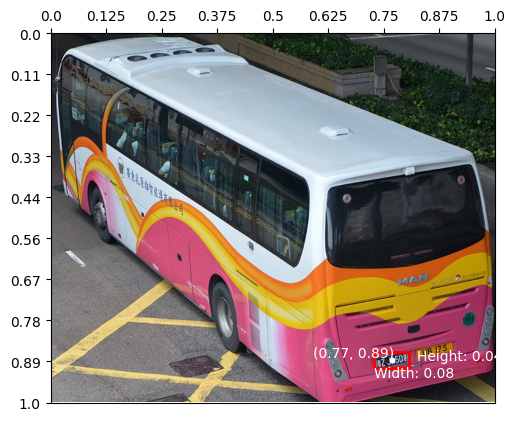

In [47]:
def visualize_yolo_bbox(image_tensor, bbox):
    print('YOLO формат\n(x_center_normalize, y_center_normalize, width_normalize, height_normalize)')
    print('bbox:\n', bbox)
    image_np = image_tensor.permute(1, 2, 0).numpy()  # (H, W, C)
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)

    h, w, _ = image_np.shape
    x_center, y_center, width, height = bbox

    # Преобразуем нормализованные координаты в пиксели
    x_center_pix = x_center * w
    y_center_pix = y_center * h
    width_pix = width * w
    height_pix = height * h

    xmin = int(x_center_pix - width_pix / 2)
    ymin = int(y_center_pix - height_pix / 2)
    xmax = int(x_center_pix + width_pix / 2)
    ymax = int(y_center_pix + height_pix / 2)

    rect = patches.Rectangle((xmin, ymin), width_pix, height_pix, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


    # Визуализируем центр
    ax.scatter(x_center_pix, y_center_pix, color='white', s=10, marker='o')
    plt.text(x_center_pix + 5, y_center_pix, f'({round(x_center,2)}, {round(y_center,2)})', fontsize=10, color='white', ha='right', va='bottom')

    plt.text(x_center_pix - 30, ymax + 15, f"Width: {width:.2f}", color='white', fontsize=10)
    plt.text(xmax + 15, y_center_pix, f"Height: {height:.2f}", color='white', fontsize=10)

    # Устанавливаем относительные оси от 0 до 1
    ax.set_xticks(np.linspace(0, w, num=9))  # 6 меток по оси X
    ax.set_yticks(np.linspace(0, h, num=10))  # 6 меток по оси Y

    ax.set_xticklabels(np.linspace(0, 1, num=9), rotation=0)
    ax.set_yticklabels(np.round(np.linspace(0, 1, num=10), 2))  # Переворот для правильного отображения Y
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.show()

yolo_box = df_train.iloc[0]['x_c':'h'].to_numpy()
visualize_yolo_bbox(img, yolo_box)

### Разделение данных на train и val

Теперь нам нужно перевести данные в формат, необходимый для обучения модели.
Для этого нужно подготовить изображения и разметку bbox-ов в определённом формате и указать пути к ним в YAML-конфиге.

```
dataset_path
├── images
│   ├── train
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   └── val
│       ├── image_3.jpg
│       └── image_4.jpg
└── labels
    ├── train
    │   ├── image_1.txt
    │   └── image_2.txt
    └── val
        ├── image_3.txt
        └── image_4.txt
```
Файлы с разметкой имеют следующий формат:
```
0 0.568359375 0.578125 0.33984375 0.64583331
```
Вначале идёт индекс класса, в нашей задаче только один класс 'plate' с индексом 0. Затем идут координаты bbox-ов в YOLO-формате.

Затем нужно в YAML-конфиге указать путь к данным. Конфиг выглядит следующим образом:
```
path: PATH/TO/DATASET # dataset root dir
train: images/train # train images (relative to 'path') 4 images
val: images/val # val images (relative to 'path') 4 images
test: # test images (optional)

# Classes
names:
  0: plate
```


Создадим функцию для создания шаблона датасета по конструкции выше, где:

* absolute_path_to_dataset: путь к основной папке датасета.

* absolute_path_to_train_images: путь к папке с тренировочными изображениями.

* absolute_path_to_train_labels: путь к папке с тренировочными метками.

* absolute_path_to_val_images: путь к папке с валидационными изображениями.

* absolute_path_to_val_labels: путь к папке с валидационными метками.

In [48]:
def create_dataset_template(path_to_create_dataset_template):
    new_dataset_path = Path(path_to_create_dataset_template)
    new_dataset_path.mkdir(exist_ok=True)
    
    path_to_train_images = Path(new_dataset_path, 'images', 'train')
    path_to_train_images.mkdir(exist_ok=True, parents=True,)
    
    path_to_train_labels = Path(new_dataset_path, 'labels', 'train')
    path_to_train_labels.mkdir(exist_ok=True, parents=True,)
    
    path_to_val_images = Path(new_dataset_path, 'images', 'val')
    path_to_val_images.mkdir(exist_ok=True, parents=True,)
    
    path_to_val_labels = Path(new_dataset_path, 'labels', 'val')
    path_to_val_labels.mkdir(exist_ok=True, parents=True,)
    
    absolute_path_to_dataset = new_dataset_path.resolve()
    absolute_path_to_train_images = path_to_train_images.resolve()
    absolute_path_to_train_labels = path_to_train_labels.resolve()
    absolute_path_to_val_images = path_to_val_images.resolve()
    absolute_path_to_val_labels = path_to_val_labels.resolve()
    
    return absolute_path_to_dataset, absolute_path_to_train_images, absolute_path_to_train_labels, absolute_path_to_val_images, absolute_path_to_val_labels

In [49]:
path_to_create_dataset_template = '/kaggle/working/dataset_plate' 
path_to_dataset, path_to_train_images, path_to_train_labels, path_to_val_images, path_to_val_labels = create_dataset_template(path_to_create_dataset_template)

Напишем функцию для копирования изображений в определенные папки и создания необходимых нам файлов с разметкой. Также создадим функцию для создания config.yaml.

In [51]:
def prepare_dataset(df, path_to_save_images, path_to_save_labels):
    for index, row in df.iterrows():
        image_path = Path(row['image_path'])
        image_name = image_path.stem
        save_path_image = Path(path_to_save_images, image_path.name)
        if not save_path_image.exists():
            shutil.copy(image_path, save_path_image)
        yolo_boxes_str = f"0 {row['x_c']} {row['y_c']} {row['w']} {row['h']}\n"
        path_to_annotation = Path(path_to_save_labels, f'{image_name}.txt')
        with open(path_to_annotation, 'a') as f_out:
            f_out.write(yolo_boxes_str)


prepare_dataset(df_train, path_to_train_images, path_to_train_labels)
prepare_dataset(df_val, path_to_val_images, path_to_val_labels)

In [53]:
def generate_yaml_config(dataset_path, path_to_train, path_to_val):
    config = {
        'path': str(dataset_path), # абсолютный путь к датасету
        'train': str(path_to_train.relative_to(dataset_path)), # путь к train-изображениям относительно dataset_path
        'val': str(path_to_val.relative_to(dataset_path)), # # путь к val-изображениям относительно dataset_path
        'names': {
            '0': 'plate'
            },
    
    }
    path_to_config = Path('config.yaml')
    with open('config.yaml', 'w') as file:
        yaml.dump(config, file)
    absolute_path_to_config = path_to_config.resolve()
    return absolute_path_to_config

generate_yaml_config(path_to_dataset, path_to_train_images, path_to_val_images)

PosixPath('/kaggle/working/config.yaml')

Ура, всё готово!

Погнали учиться!

In [15]:
model = YOLO('yolo11s.pt')

Подберем аугментации. Автомобильный номер довольно мелкий объект, если только он не совсем на переднем плане. Поэтому нам необходимы небольшие изменения картинки. Я пробовала, как мне казалось, щадящие изменения изображения, но в итоге тут легко перестараться - даже, казалось бы, небольшие сдвиги могут перекрыть автомобильный номер, либо совсем вытянуть изображение, что тоже в данной задаче не очень нужно. 

In [13]:
hparams = {
    "degrees": 3.0,        
    "translate": 0.02,     
    "scale": 0.05,       
    "shear": 0.5,        
    "perspective": 0.0005, 
    "flipud": 0.0,        
    "fliplr": 0.0,       
    "hsv_h": 0.01,
    "hsv_s": 0.25,
    "hsv_v": 0.15,
    "mosaic": 0.02,    
    "mixup": 0.00,   
}

In [15]:
train_results = model.train(data='config.yaml', epochs=100, imgsz=1280, batch=8, rect=True, optimizer="AdamW", lr0=0.0001, **hparams)

Ultralytics 8.3.221 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=config.yaml, degrees=3.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.25, hsv_v=0.15, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=0.02, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0005, plots=True, pose=12.0, pre

Exception in thread Thread-13 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/resource_s

     27/100      4.04G      0.777     0.3928     0.9405          8       1280: 9% ━─────────── 74/788 3.9it/s 17.3s<3:05


KeyboardInterrupt: 

Обучение пришлось продолжить позже, благо, из документации выяснилось, что YOLO позволяет продолжить обучение с последней сохраненной эпохи с помощью параметра resume. Удобно :)

In [10]:
model = YOLO("/kaggle/input/best-final/best_25.pt")  # load a partially trained model

train_results = model.train(resume=True)

Ultralytics 8.3.221 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=config.yaml, degrees=3.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.25, hsv_v=0.15, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/best-final/best_25.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0005, pl

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        699        761      0.952      0.925      0.965      0.847
Speed: 0.5ms preprocess, 14.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


В итоге мы получаем mAP аж на 0.84! Считаю, что это уже довольно круто. И думаю, для решения 2 части поставленной нами задачки будет достаточно.

Как я уже говорила, изначально не размеченные данные дали буст в метриках. Например, при постановке эксперимента без них, mAP был около 0.7 - так что прирост приличный.

Посмотрим на картинку, которую модель прежде не видела. 

In [11]:
im = cv2.imread('/kaggle/input/car-plate/data_jpg/images/test/000103_0.jpg')
results = model.predict(source=im, save=True)


0: 928x1280 2 plates, 55.3ms
Speed: 6.8ms preprocess, 55.3ms inference, 1.4ms postprocess per image at shape (1, 3, 928, 1280)
Results saved to /kaggle/working/runs/detect/predict


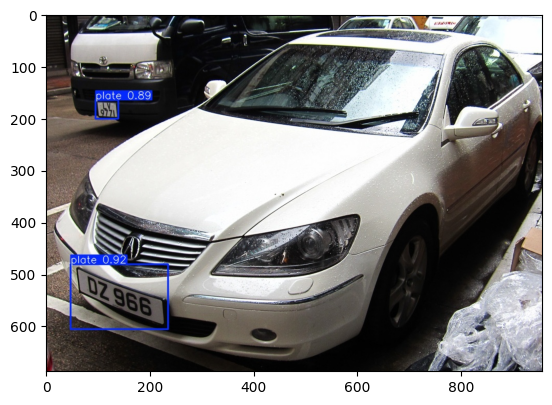

In [12]:
res = cv2.imread('/kaggle/working/runs/detect/predict/image0.jpg')
plt.imshow(res[:, :, ::-1])
plt.show()


0: 800x1280 1 plate, 59.6ms
Speed: 6.8ms preprocess, 59.6ms inference, 1.6ms postprocess per image at shape (1, 3, 800, 1280)
Results saved to /kaggle/working/runs/detect/predict


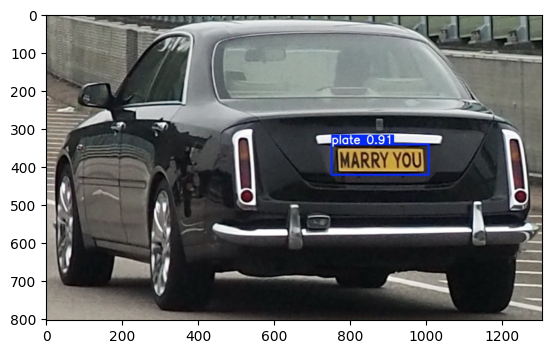

In [13]:
im = cv2.imread('/kaggle/input/car-plate/data_jpg/images/test/000112_0.jpg')
results = model.predict(source=im, save=True)
res = cv2.imread('/kaggle/working/runs/detect/predict/image0.jpg')
plt.imshow(res[:, :, ::-1])
plt.show()

Результаты поражают! Модель отлично определяет положение автомобильных номеров: score высокий, даже когда номер на втором плане. Круто!

In [14]:
data_path = '/kaggle/input/car-plate/data_jpg'
test_image_paths = list(Path(data_path).rglob('images/test/*.jpg'))

In [16]:
path_result = 'test_pred_bboxes.txt'
with open(path_result, 'w') as f:
    f.write('image_name,x_1,y_1,x_2,y_2,conf\n')
    for img_path in test_image_paths:
        results = model.predict(source=str(img_path), save=False, verbose=False, conf=0.1)
        for res in results:
            # Если нет детекций — пропускаем
            if res.boxes is None or len(res.boxes) == 0:
                continue
            xyxy = res.boxes.xyxy.cpu().numpy()      # [[x1,y1,x2,y2], ...]
            conf = res.boxes.conf.cpu().numpy() 
            image_name = f"test/{img_path.name}"
            for (x1, y1, x2, y2), c in zip(xyxy, conf):
                line = [image_name, int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2)), float(round(c, 3))]
                f.write(','.join(map(str, line)) +'\n')

print('Файл с результатами детекций записан!')

Файл с результатами детекций записан!


Теперь нам остался только OCR.

# Часть вторая. Распознавание автомобильных номеров

In [5]:
import os
import cv2
import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import paddleocr

In [110]:
ocr = paddleocr.PaddleOCR(
        use_angle_cls=True, 
        lang='ch',
        use_gpu=False,
        show_log=False
    )

Ещё раз взглянем на размеченные номера.

In [164]:
data_path ='/kaggle/input/car-plate/data_jpg'
cols=['image_name', 'x_1', 'y_1', 'x_2', 'y_2', 'plate']
annot_path = os.path.join(data_path, 'annotation/train_final_annot.txt')
df = pd.read_csv(annot_path, sep=",", names=cols, skiprows=1, header=None)
df.head()

,image_name,x_1,y_1,x_2,y_2,plate
0,train/000000_0.jpg,566,558,626,586,粤ZJA50港
1,train/000000_0.jpg,635,538,705,570,UB175
2,train/000001_0.jpg,1003,791,1160,831,MB3185
3,train/000002_0.jpg,1077,565,1209,604,NG8134
4,train/000004_0.jpg,972,627,1120,668,TT583


In [169]:
df['image_path'] = '/kaggle/input/car-plate/data_jpg/images/'+ df['image_name']
df.head()

,image_name,x_1,y_1,x_2,y_2,plate,image_path
0,train/000000_0.jpg,566,558,626,586,粤ZJA50港,/kaggle/input/car-plate/data_jpg/images/train/...
1,train/000000_0.jpg,635,538,705,570,UB175,/kaggle/input/car-plate/data_jpg/images/train/...
2,train/000001_0.jpg,1003,791,1160,831,MB3185,/kaggle/input/car-plate/data_jpg/images/train/...
3,train/000002_0.jpg,1077,565,1209,604,NG8134,/kaggle/input/car-plate/data_jpg/images/train/...
4,train/000004_0.jpg,972,627,1120,668,TT583,/kaggle/input/car-plate/data_jpg/images/train/...


Возьмем какой-нибудь пример и обрежем его по bbox, посмотрим как работает PaddleOCR.

In [286]:
i=0
some_img = cv2.imread(df.iloc[i]['image_path'])
x1, y1, x2, y2 = df.iloc[i]['x_1':'y_2'].to_numpy()
crop_img = some_img[int(y1):int(y2), int(x1):int(x2)]

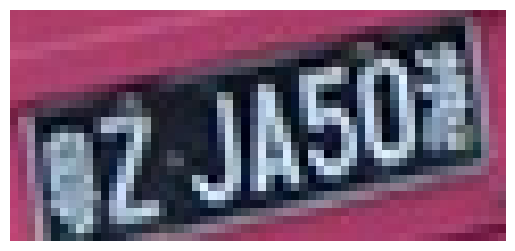

In [287]:
plt.imshow(crop_img[:, :, ::-1])
plt.axis("off")
plt.show()

In [288]:
results_train = ocr(crop_img, cls = True)

In [289]:
print("Предсказанный номер: ", results_train[1][0][0])
print("Правильный номер: ", df.iloc[i]['plate'])

Предсказанный номер:  粤ZJA50
Правильный номер:  粤ZJA50港


В целом, получилось достаточно неплохо. Последний иероглиф он так себе определил, но остальные точь-в-точь. Можно брать.

Возьмем тестовый набор с детекциями, которые мы получили от YOLO.

In [54]:
cols=['image_name', 'x_1', 'y_1', 'x_2', 'y_2', 'conf']
df_test = pd.read_csv('/kaggle/input/test-detect-result/test_pred_bboxes.txt', sep=",", names=cols, skiprows=1, header=None)
df_test.head()

,image_name,x_1,y_1,x_2,y_2,conf
0,test/004297_0.jpg,238,490,551,577,0.916
1,test/004297_0.jpg,265,0,412,37,0.836
2,test/002337_0.jpg,794,333,1081,408,0.901
3,test/002337_0.jpg,0,268,75,346,0.721
4,test/004050_1.jpg,0,252,63,301,0.936


In [55]:
df_test['image_path'] = '/kaggle/input/car-plate/data_jpg/images/'+ df_test['image_name']
df_test.head()

,image_name,x_1,y_1,x_2,y_2,conf,image_path
0,test/004297_0.jpg,238,490,551,577,0.916,/kaggle/input/car-plate/data_jpg/images/test/0...
1,test/004297_0.jpg,265,0,412,37,0.836,/kaggle/input/car-plate/data_jpg/images/test/0...
2,test/002337_0.jpg,794,333,1081,408,0.901,/kaggle/input/car-plate/data_jpg/images/test/0...
3,test/002337_0.jpg,0,268,75,346,0.721,/kaggle/input/car-plate/data_jpg/images/test/0...
4,test/004050_1.jpg,0,252,63,301,0.936,/kaggle/input/car-plate/data_jpg/images/test/0...


In [290]:
i=10
some_img = cv2.imread(df_test.iloc[i]['image_path'])
x1, y1, x2, y2 = df_test.iloc[i]['x_1':'y_2'].to_numpy()
crop_img = some_img[int(y1):int(y2), int(x1):int(x2)]

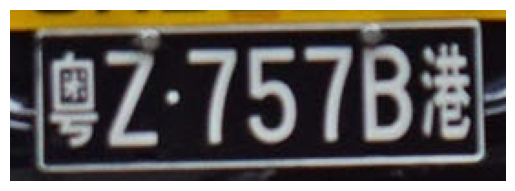

In [291]:
plt.imshow(crop_img[:, :, ::-1])
plt.axis("off")
plt.show()

In [292]:
results = ocr(crop_img, cls = True)

In [293]:
print(results[1][0][0])

粤Z·757B港


На примере выше видим результат PaddleOCR на одном тестовом примере. Получилось круто! Но модель периодически всё норовит добавить точку, а нам она не нужна. 

Напишем функцию, которая обрабатывает все номера из тестового набора, очищает результат от лишних символов и записывает результат в файл.

In [150]:
def paddle_ocr_with_prepare(df, path_result):
    with open(path_result, 'w') as f:
        f.write('image_name,plate\n')
        for index, row in df.iterrows():
            frame = cv2.imread(row['image_path'])
            x1, y1, x2, y2 = row['x_1':'y_2'].to_numpy()
            crop_img = frame[int(y1):int(y2), int(x1):int(x2)]
            results = ocr(crop_img, cls = True)
            if len(results[1]) == 0:
                continue
            #Номер слитный, но модель иногда разделяет его, сольем в один
            merge_result = ''.join(char[0] for char in results[1])
            #Теперь почистим от ненужных нам символов, оставим только буквы (в том числе иероглифы) и цифры
            clean_result = re.sub(r"[^\w\u4e00-\u9fff]", "", merge_result)
            image_name = row['image_name']
            line = [image_name, clean_result, x1, y1, x2, y2]
            f.write(','.join(map(str, line)) +'\n')
    print('Файл с результатами распознавания номеров записан!')

In [151]:
path_result = 'test_pred_plates_new.txt'
paddle_ocr_with_prepare(df_test, path_result)

Файл с результатами распознавания номеров записан!


Отрисуем полученный результат.

In [152]:
cols=['image_name', 'plate', 'x_1', 'y_1', 'x_2', 'y_2']
df_ocr = pd.read_csv('/kaggle/working/test_pred_plates_new.txt', sep=",", names=cols, skiprows=1, header=None)
df_ocr.head()

,image_name,plate,x_1,y_1,x_2,y_2
0,test/004297_0.jpg,NC488,238,490,551,577
1,test/002337_0.jpg,UG8191,794,333,1081,408
2,test/002337_0.jpg,66,0,268,75,346
3,test/3757.jpg,苏L0602X,339,368,545,448
4,test/3757.jpg,皖BFM6,7,329,128,393


In [153]:
df_ocr['image_path'] = '/kaggle/input/car-plate/data_jpg/images/' + df_ocr['image_name']
df_ocr.head()

,image_name,plate,x_1,y_1,x_2,y_2,image_path
0,test/004297_0.jpg,NC488,238,490,551,577,/kaggle/input/car-plate/data_jpg/images/test/0...
1,test/002337_0.jpg,UG8191,794,333,1081,408,/kaggle/input/car-plate/data_jpg/images/test/0...
2,test/002337_0.jpg,66,0,268,75,346,/kaggle/input/car-plate/data_jpg/images/test/0...
3,test/3757.jpg,苏L0602X,339,368,545,448,/kaggle/input/car-plate/data_jpg/images/test/3...
4,test/3757.jpg,皖BFM6,7,329,128,393,/kaggle/input/car-plate/data_jpg/images/test/3...


plt.title не поддерживает написание иероглифов, вместо них он ставит загадочные квадратики. Для того, чтобы он нормально отображал иероглифы, необходимо скачать шрифт для иероглифов.

In [158]:
!apt-get install -y fonts-noto-cjk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 132 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 1s (60.3 MB/s)         
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 128639 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


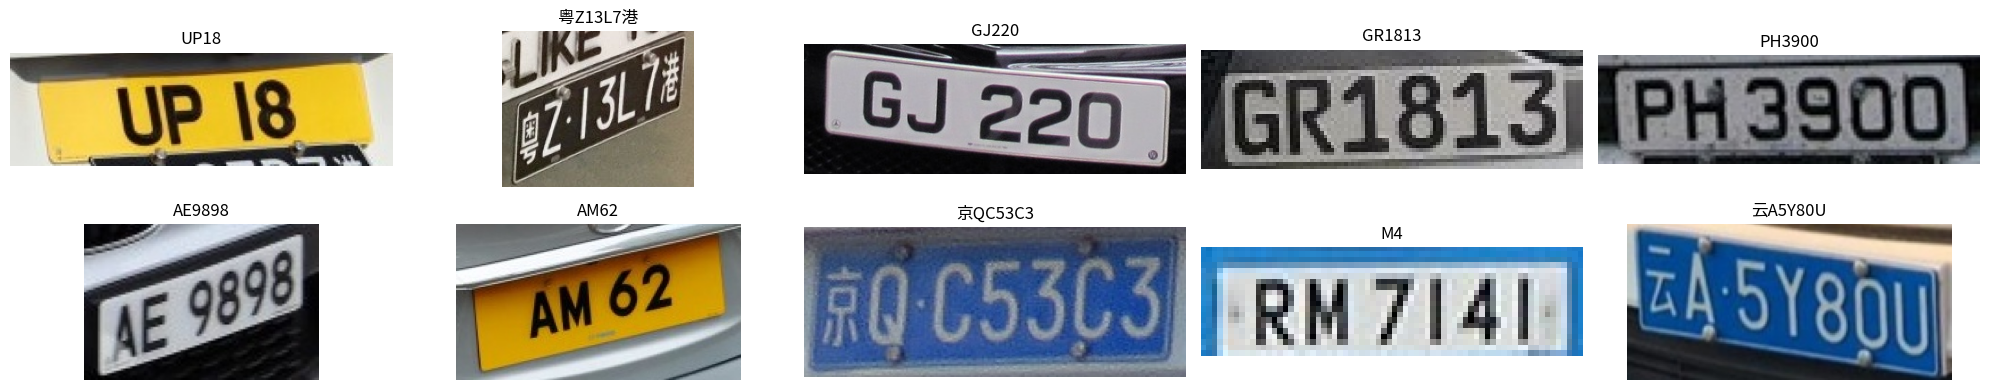

In [159]:
SAMPLE_SIZE = 10
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(df_ocr), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Noto Sans CJK JP'  
for i, idx in enumerate(random_idxs, 1):
    item = df_ocr.loc[idx]
    text = item['plate']
    image = cv2.imread(item['image_path'])
    x1, y1, x2, y2 = item['x_1':'y_2'].to_numpy()
    crop_img = image[y1:y2, x1:x2]
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(crop_img[:, :, ::-1])
    plt.title(text)
    plt.axis('off')
    

plt.tight_layout()
plt.show()

Ура, сработало! В большинстве случаев текст распознан отлично. Задача решена.